In [41]:
# %matplotlib inline

import pandas as pd
import datetime as dt

from functools import partial

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

%matplotlib widget

In [42]:
# We will analyse the pcbc data from excel in this notebook
FILE_LOC = '../data/ptfi_1/'
FILE_NAME = 'DP_block_grade estimates_actual tons_dp coordinate.xlsx'

GIF_SAVE_LOC = '../outputs/gifs/'

draw_tons = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Drawn Tons')
cu_pcbc = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Cu_PCBC')
au_pcbc = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Au_PCBC')
dp_coords = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='DP_Coordinates')

# Draw Tons

## Analysis and Cleaning

In [43]:
draw_tons.count()

Draw Point Name        2050
2015-08-01 00:00:00    2050
2015-09-01 00:00:00    2050
2015-10-01 00:00:00    2050
2015-11-01 00:00:00    2050
                       ... 
2022-06-01 00:00:00    2050
2022-07-01 00:00:00    2050
2022-08-01 00:00:00    2050
2022-09-01 00:00:00    2050
2022-10-01 00:00:00    2050
Length: 88, dtype: int64

In [44]:
names = {
    'Draw Point Name': 'name'
}

cols = list(draw_tons.columns)
for col_name in cols:
    if isinstance(col_name, dt.datetime):
        names[col_name] = f'{col_name.year}_{col_name.month}'
        
draw_tons = draw_tons.rename(
    columns = names
)

draw_tons = draw_tons.set_index('name').astype(float)

In [45]:
draw_tons

,2015_8,2015_9,2015_10,2015_11,2015_12,2016_1,2016_2,2016_3,2016_4,2016_5,...,2022_1,2022_2,2022_3,2022_4,2022_5,2022_6,2022_7,2022_8,2022_9,2022_10
name,,,,,,,,,,,,,,,,,,,,,
P04-11W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P04-12W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P04-13W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P04-14W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P04-15W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P92-07E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P92-08E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P92-09E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Create a set of drawpoints (should be able to be used across all datasets except drawpoint coordinates)
drawpoints = list(draw_tons.index.values)

# Creates a dictionary of lists to draw in a bar chart
draw_tons_data = draw_tons.to_dict(orient='list')

# Creates a dictionary of dictionaries to be referenced across the other datasets.
draw_tons_dict = draw_tons.to_dict(orient='index')

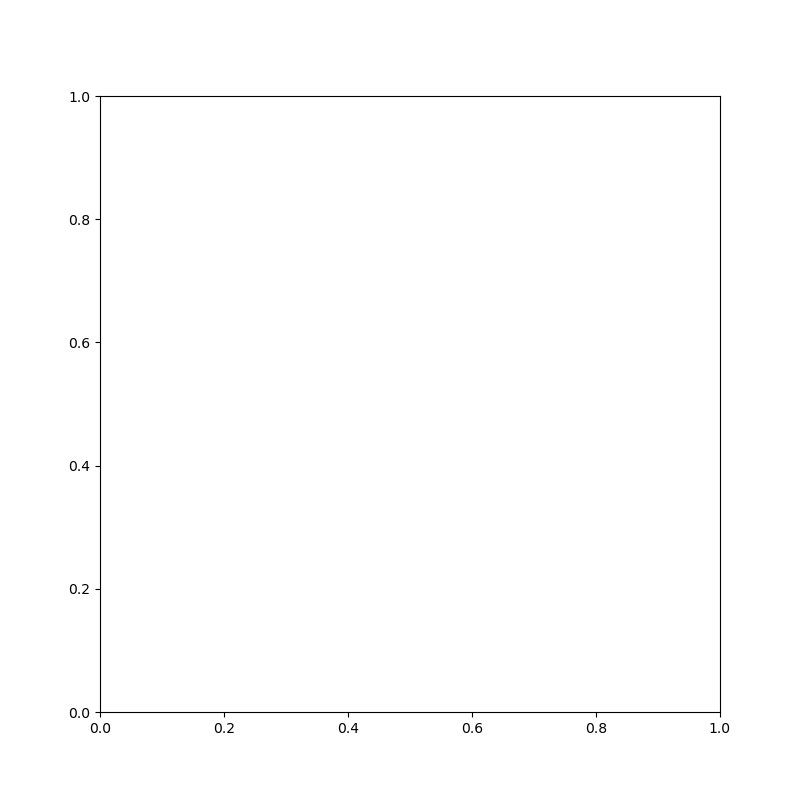

In [47]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8)

In [48]:
def get_year_month(i):
    FIRST_YEAR, FIRST_MONTH = 2015, 7 # 7 is August
    year = FIRST_YEAR + int((FIRST_MONTH + i) / 12)
    month = (FIRST_MONTH + i) % 12
    return year, month

def get_points(elapsed_months, df):
    year, month = get_year_month(elapsed_months)
    return df[f'{year}_{month + 1}']

def animate_draw_data(i, dfs, xlim, ylim):
    ax.clear()
    
    # given an i (elapsed months), get the draw data from that month from the dictionary
    for df in dfs:
        points = get_points(i, df)

        # Plot that data on a 2D graph
        ax.plot(
            points
        )
    
    # Set the x and y axis to display a fixed range
    # We only care about the first 610 or so drawpoints because none of the later ones have draw data
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set a title for the given month and year
    year, month = get_year_month(i)
    ax.set_title(f'{month + 1}, {year}')

## Animate

IndexError: list index out of range

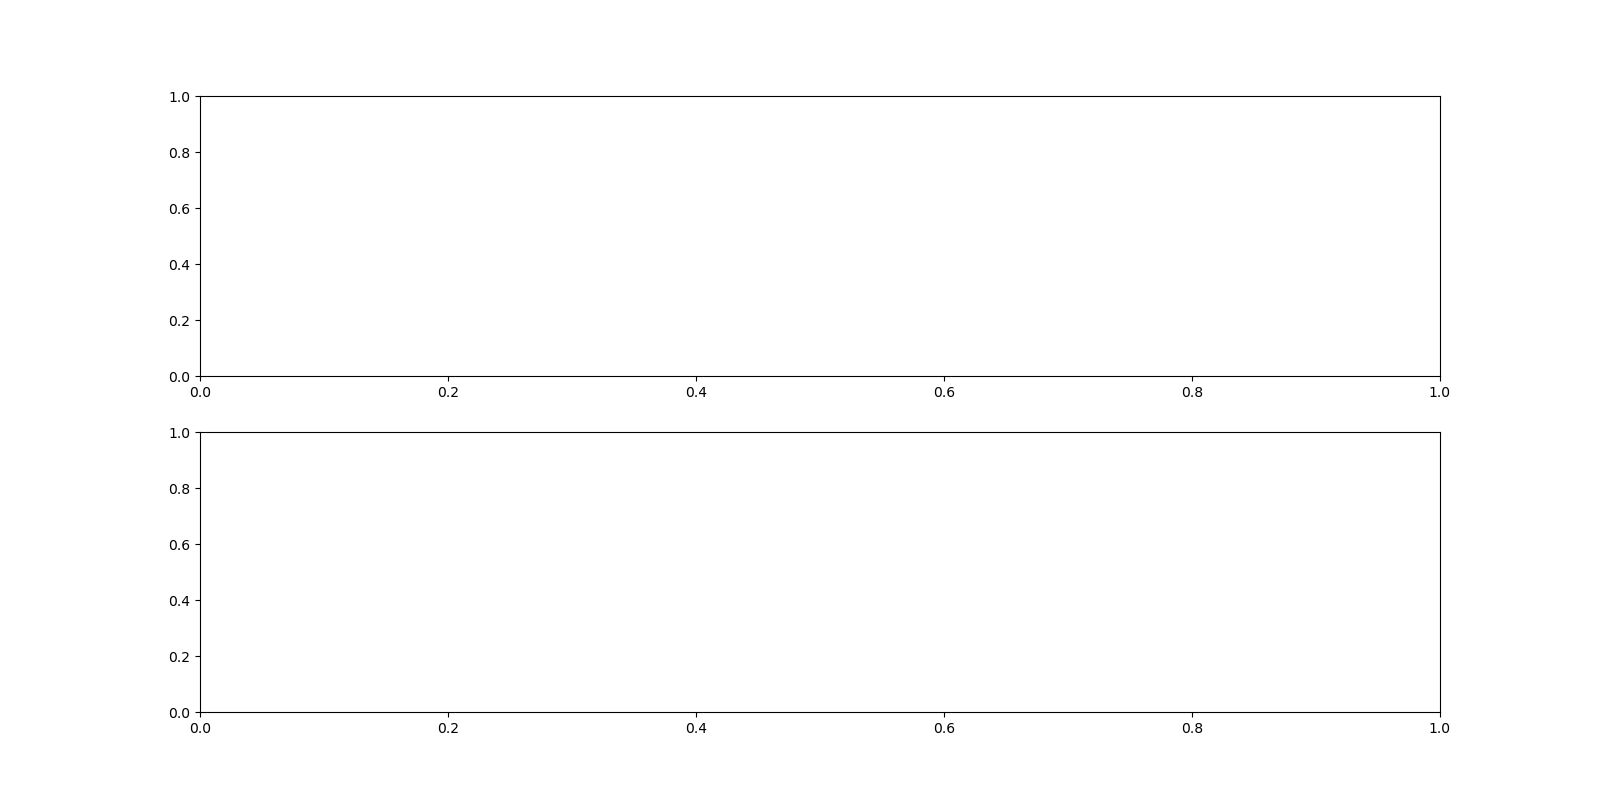

In [49]:
# Save the animation
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(16, 8)

ani = FuncAnimation(
    fig, 
    animate_draw_data, 
    fargs=[[draw_tons_data], [0, 610], [0, 20000]],
    frames=len(draw_tons_data),
    interval=500, 
    repeat=False
)
# plt.close()

# Save the animation as an animated GIF
ani.save(
    GIF_SAVE_LOC + "draw_tons.gif", 
    dpi=300,
    writer=PillowWriter(fps=2)
)

<img src="draw_tons.gif" width="650" height="650"/>

# Copper PCBC

In [ ]:
cu_pcbc.count()

Draw Point Name        2050
2015-08-01 00:00:00    2050
2015-09-01 00:00:00    2050
2015-10-01 00:00:00    2050
2015-11-01 00:00:00    2050
                       ... 
2022-06-01 00:00:00    2050
2022-07-01 00:00:00    2050
2022-08-01 00:00:00    2050
2022-09-01 00:00:00    2050
2022-10-01 00:00:00    2050
Length: 88, dtype: int64

---

not sure why one of the columns is named 44835

---

In [ ]:
names = {
    'Draw Point Name': 'name',
    44835: '2022_10'
}

cols = list(cu_pcbc.columns)
for col_name in cols:
    if isinstance(col_name, dt.datetime):
        names[col_name] = f'{col_name.year}_{col_name.month}'
        
cu_pcbc = cu_pcbc.rename(
    columns = names
)

cu_pcbc = cu_pcbc.set_index('name').astype(float)

In [ ]:
cu_pcbc

,2015_8,2015_9,2015_10,2015_11,2015_12,2016_1,2016_2,2016_3,2016_4,2016_5,...,2022_1,2022_2,2022_3,2022_4,2022_5,2022_6,2022_7,2022_8,2022_9,2022_10
name,,,,,,,,,,,,,,,,,,,,,
P04-11W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P04-12W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P04-13W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P04-14W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P04-15W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P92-07E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P92-08E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P92-09E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Creates a dictionary of lists to draw in a bar chart
cu_pcbc_data = cu_pcbc.to_dict(orient='list')

# Creates a dictionary of dictionaries to be referenced across the other datasets.
cu_pcbc_dict = cu_pcbc.to_dict(orient='index')

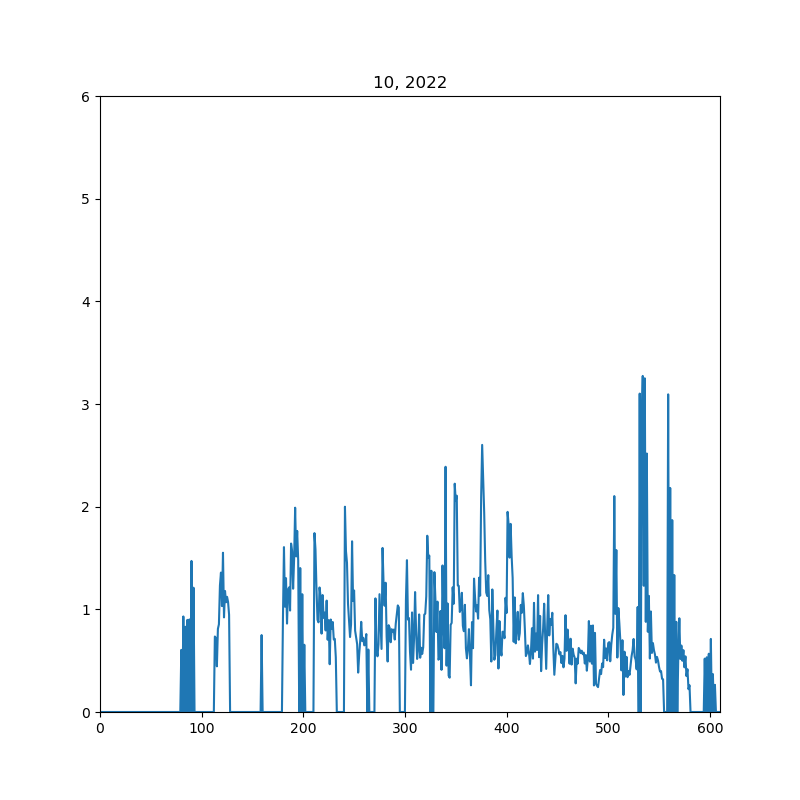

In [ ]:
# Save the animation
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8)

ani = FuncAnimation(
    fig, 
    animate_draw_data, 
    fargs=[[cu_pcbc_data], [0, 610], [0, 6]],
    frames=len(cu_pcbc_data),
    interval=500, 
    repeat=False
)
# plt.close()

# Save the animation as an animated GIF
ani.save(
    GIF_SAVE_LOC + "cu_pcbc.gif", 
    dpi=300,
    writer=PillowWriter(fps=2)
)

<img src="cu_pcbc.gif" width="650" height="650"/>

In [ ]:
for drawpoint, data in draw_tons_dict.items():
    for date, val in data.items():
        cu = cu_pcbc_dict[drawpoint][date]
        if (val != 0.0) ^ (cu != 0.0):
            print(drawpoint, date, f'dt: {val}, cu: {cu}')
            
print('done')

done


# Gold PCBC

In [ ]:
au_pcbc.count()

Draw Point Name        2050
2015-08-01 00:00:00    2050
2015-09-01 00:00:00    2050
2015-10-01 00:00:00    2050
2015-11-01 00:00:00    2050
                       ... 
2022-06-01 00:00:00    2050
2022-07-01 00:00:00    2050
2022-08-01 00:00:00    2050
2022-09-01 00:00:00    2050
2022-10-01 00:00:00    2050
Length: 88, dtype: int64

In [ ]:
names = {
    'Draw Point Name': 'name'
}

cols = list(au_pcbc.columns)
for col_name in cols:
    if isinstance(col_name, dt.datetime):
        names[col_name] = f'{col_name.year}_{col_name.month}'
        
au_pcbc = au_pcbc.rename(
    columns = names
)

au_pcbc = au_pcbc.set_index('name').astype(float)

In [ ]:
au_pcbc

,2015_8,2015_9,2015_10,2015_11,2015_12,2016_1,2016_2,2016_3,2016_4,2016_5,...,2022_1,2022_2,2022_3,2022_4,2022_5,2022_6,2022_7,2022_8,2022_9,2022_10
name,,,,,,,,,,,,,,,,,,,,,
P04-11W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P04-12W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P04-13W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P04-14W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P04-15W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P92-07E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P92-08E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P92-09E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Creates a dictionary of lists to draw in a bar chart
au_pcbc_data = au_pcbc.to_dict(orient='list')

# Creates a dictionary of dictionaries to be referenced across the other datasets.
au_pcbc_dict = au_pcbc.to_dict(orient='index')

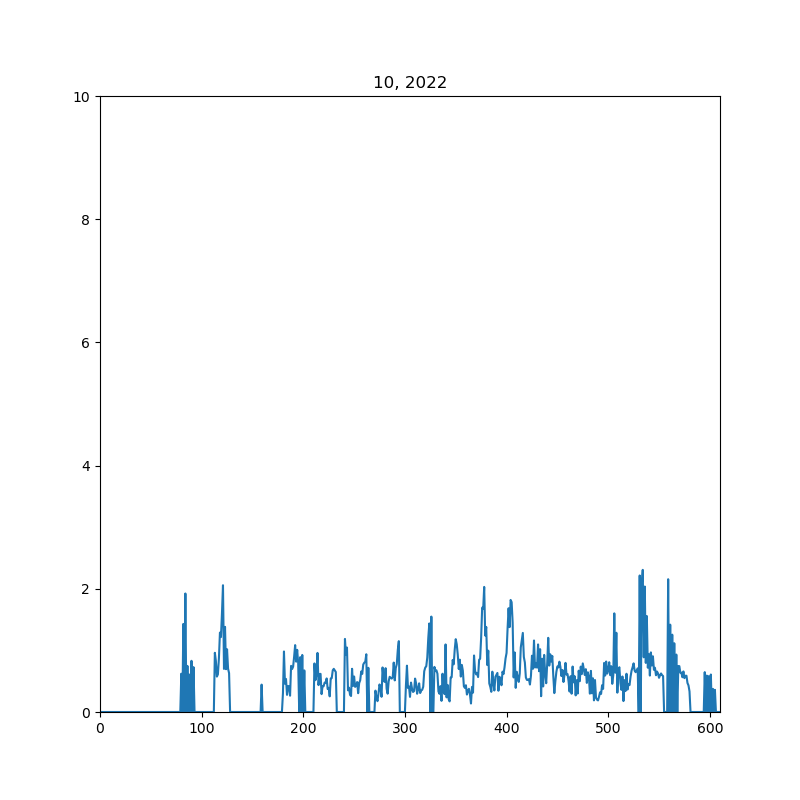

In [ ]:
# Save the animation
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8)

ani = FuncAnimation(
    fig, 
    animate_draw_data, 
    fargs=[[au_pcbc_data], [0, 610], [0, 10]],
    frames=len(au_pcbc_data),
    interval=500, 
    repeat=False
)
# plt.close()

# Save the animation as an animated GIF
ani.save(
    GIF_SAVE_LOC + "au_pcbc.gif", 
    dpi=300,
    writer=PillowWriter(fps=2)
)

<img src="au_pcbc.gif" width="650" height="650"/>

In [ ]:
for drawpoint, data in draw_tons_dict.items():
    for date, val in data.items():
        au = au_pcbc_dict[drawpoint][date]
        if (val != 0.0) ^ (au != 0.0):
            print(drawpoint, date, f'dt: {val}, au: {au}')
            
print('done')

done


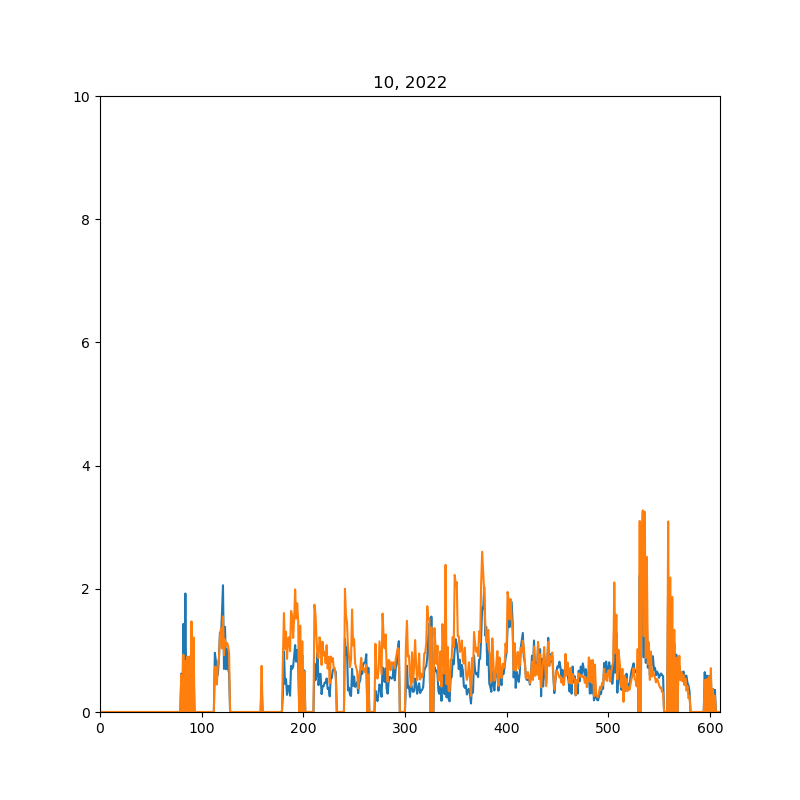

In [ ]:
# Save the animation
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8)

ani = FuncAnimation(
    fig, 
    animate_draw_data, 
    fargs=[[au_pcbc_data, cu_pcbc_data], [0, 610], [0, 10]],
    frames=len(au_pcbc_data),
    interval=500, 
    repeat=False
)
# plt.close()

# Save the animation as an animated GIF
ani.save(
    GIF_SAVE_LOC + "au_cu_pcbc.gif", 
    dpi=300,
    writer=PillowWriter(fps=2)
)

<img src="au_cu_pcbc.gif" width="650" height="650"/>

# Drawpoint Coordinates

In [ ]:
dp_coords.count()

Draw Point Name    2034
X-dpt              2034
Y-dpt              2034
Z-dpt              2034
dtype: int64

----

We can see that there are fewer drawpoint coordinates than drawpoints as seen in the other data sets (2034 vs 2050). What this means is that there will be some drawpoints without coordinates. Perhaps Ryan can help us find the remaining ones.

As will be seen later down below though, there are 44 drawpoints with location data but without location data, and 28 drawpoints with location data but no draw data

----

In [ ]:
dp_coords = dp_coords.rename(
    columns={
        "Draw Point Name": "name", 
        "X-dpt": "x",
        'Y-dpt': 'y',
        'Z-dpt': 'z'
    }
)

dp_coords_dict = dp_coords.to_dict(orient='index')

Text(0.5, 0, 'z')

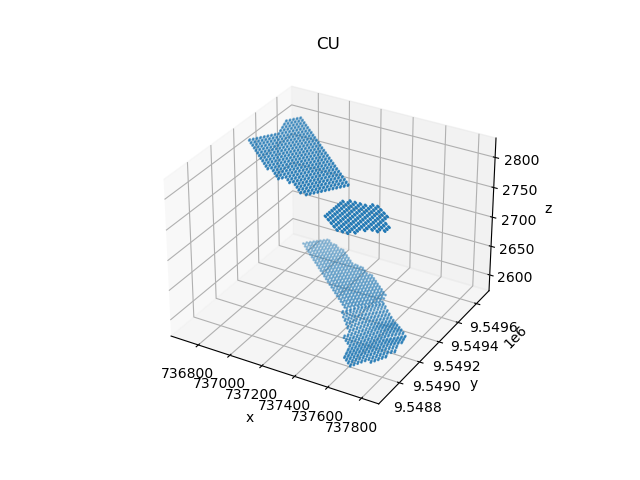

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x7fa6894d5a30>>
Traceback (most recent call last):
  File "/Users/benjaminwong/opt/anaconda3/lib/python3.9/site-packages/tornado/ioloop.py", line 905, in _run
    return self.callback()
  File "/Users/benjaminwong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1198, in _on_timer
    ret = func(*args, **kwargs)
  File "/Users/benjaminwong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py", line 1408, in _step
    still_going = super()._step(*args)
  File "/Users/benjaminwong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py", line 1107, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/Users/benjaminwong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py", line 1126, in _draw_next_frame
    self._draw_frame(framedata)
  File "/Users/benjaminwong/o

In [ ]:
from mpl_toolkits import mplot3d

# %matplotlib qt

fig = plt.figure()
ax = plt.axes(projection='3d')

element = 'CU'

ax.scatter3D(
    dp_coords['x'], 
    dp_coords['y'], 
    dp_coords['z'],
    s=1
)
ax.set_title(element)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [ ]:
unique_dp_ids = dp_coords.name.unique()
dps_no_loc_data = set()

In [ ]:
uids = drawpoints
for name in uids:
    if name not in unique_dp_ids:
        dps_no_loc_data.add(name)
          
print(dps_no_loc_data)
print(len(dps_no_loc_data))

{'P63-13E', 'P63-16E', 'P62-16W', 'P50-05W', 'P62-17W', 'P61-22E', 'P62-11E', 'P60-22W', 'P62-20W', 'P62-23W', 'P61-22W', 'P62-15W', 'P55-17E', 'P60-21E', 'P62-22W', 'P60-21W', 'P61-21E', 'P62-22E', 'P66-19E', 'P61-21W', 'P63-20E', 'P63-15E', 'P61-23W', 'P54-17W', 'P59-21W', 'P61-11W', 'P63-18E', 'P65-19W', 'P53-12E', 'P62-18W', 'P62-14W', 'P62-21E', 'P51-05E', 'P63-21E', 'P63-17E', 'P62-23E', 'P62-13W', 'P62-19W', 'P63-22E', 'P52-12W', 'P63-19E', 'P63-23E', 'P63-14E', 'P62-21W'}
44


In [ ]:
uids = list(cu_pcbc.index.values)
for name in uids:
    if name not in unique_dp_ids:
        dps_no_loc_data.add(name)
          
print(dps_no_loc_data)
print(len(dps_no_loc_data))

{'P63-13E', 'P63-16E', 'P62-16W', 'P50-05W', 'P62-17W', 'P61-22E', 'P62-11E', 'P60-22W', 'P62-20W', 'P62-23W', 'P61-22W', 'P62-15W', 'P55-17E', 'P60-21E', 'P62-22W', 'P60-21W', 'P61-21E', 'P62-22E', 'P66-19E', 'P61-21W', 'P63-20E', 'P63-15E', 'P61-23W', 'P54-17W', 'P59-21W', 'P61-11W', 'P63-18E', 'P65-19W', 'P53-12E', 'P62-18W', 'P62-14W', 'P62-21E', 'P51-05E', 'P63-21E', 'P63-17E', 'P62-23E', 'P62-13W', 'P62-19W', 'P63-22E', 'P52-12W', 'P63-19E', 'P63-23E', 'P63-14E', 'P62-21W'}
44


In [ ]:
uids = list(au_pcbc.index.values)
for name in uids:
    if name not in unique_dp_ids:
        dps_no_loc_data.add(name)
          
print(dps_no_loc_data)
print(len(dps_no_loc_data))

{'P63-13E', 'P63-16E', 'P62-16W', 'P50-05W', 'P62-17W', 'P61-22E', 'P62-11E', 'P60-22W', 'P62-20W', 'P62-23W', 'P61-22W', 'P62-15W', 'P55-17E', 'P60-21E', 'P62-22W', 'P60-21W', 'P61-21E', 'P62-22E', 'P66-19E', 'P61-21W', 'P63-20E', 'P63-15E', 'P61-23W', 'P54-17W', 'P59-21W', 'P61-11W', 'P63-18E', 'P65-19W', 'P53-12E', 'P62-18W', 'P62-14W', 'P62-21E', 'P51-05E', 'P63-21E', 'P63-17E', 'P62-23E', 'P62-13W', 'P62-19W', 'P63-22E', 'P52-12W', 'P63-19E', 'P63-23E', 'P63-14E', 'P62-21W'}
44


In [ ]:
dps_no_draw_data = set()

for name in unique_dp_ids:
    if name not in uids:
        dps_no_draw_data.add(name)
        
print(dps_no_draw_data)
print(len(dps_no_draw_data))

{'P54-04E', 'P69-19W', 'P68-19W', 'P71-20E', 'P76-22W', 'P55-04W', 'P76-22E', 'P76-23W', 'P57-05E', 'P54-04W', 'P70-20W', 'P56-04E', 'P55-04E', 'P56-05W', 'P77-22E', 'P56-05E', 'P75-22W', 'P70-19E', 'P53-05W', 'P77-23E', 'P54-05E', 'P53-04W', 'P53-04E', 'P69-19E', 'P55-05W', 'P54-05W', 'P52-04W', 'P55-05E'}
28


ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x7fa6894d5a30>>
Traceback (most recent call last):
  File "/Users/benjaminwong/opt/anaconda3/lib/python3.9/site-packages/tornado/ioloop.py", line 905, in _run
    return self.callback()
  File "/Users/benjaminwong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1198, in _on_timer
    ret = func(*args, **kwargs)
  File "/Users/benjaminwong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py", line 1408, in _step
    still_going = super()._step(*args)
  File "/Users/benjaminwong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py", line 1107, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/Users/benjaminwong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py", line 1126, in _draw_next_frame
    self._draw_frame(framedata)
  File "/Users/benjaminwong/o